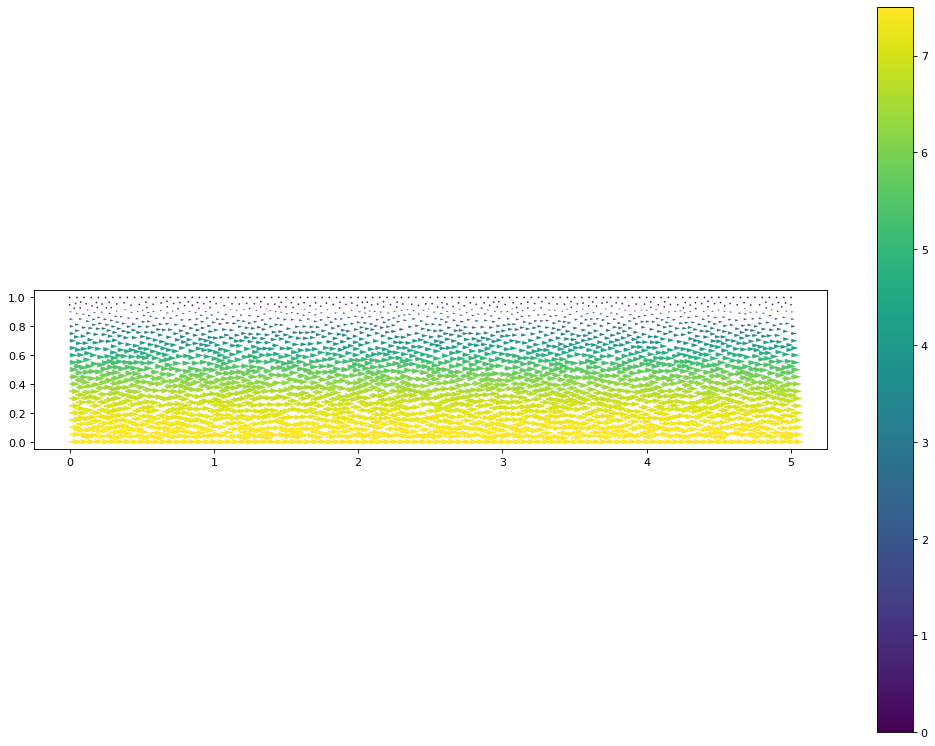

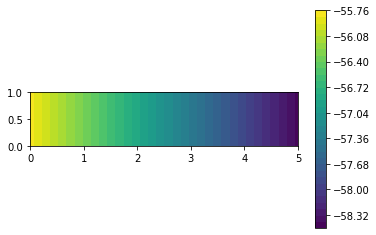

Q = 10, case:no stenosis
u_par_f = -15*x[1]**2/2 + 15/2


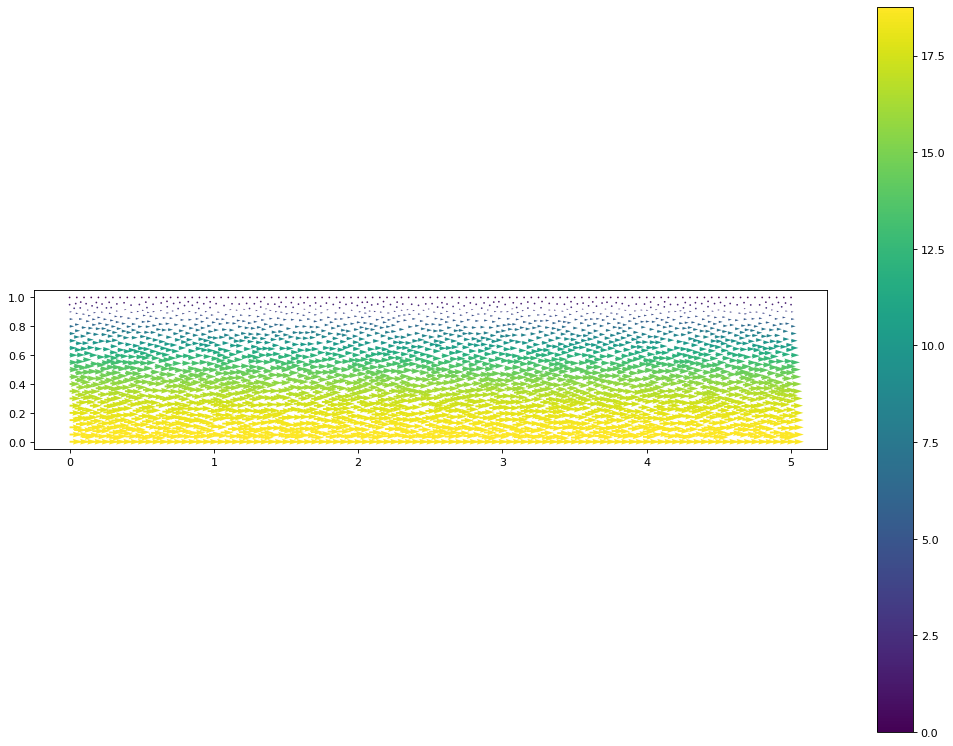

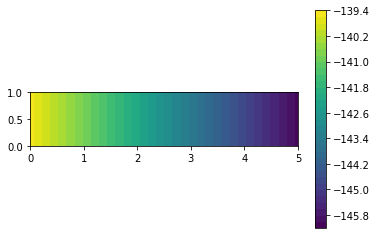

Q = 25, case:no stenosis
u_par_f = -75*x[1]**2/4 + 75/4


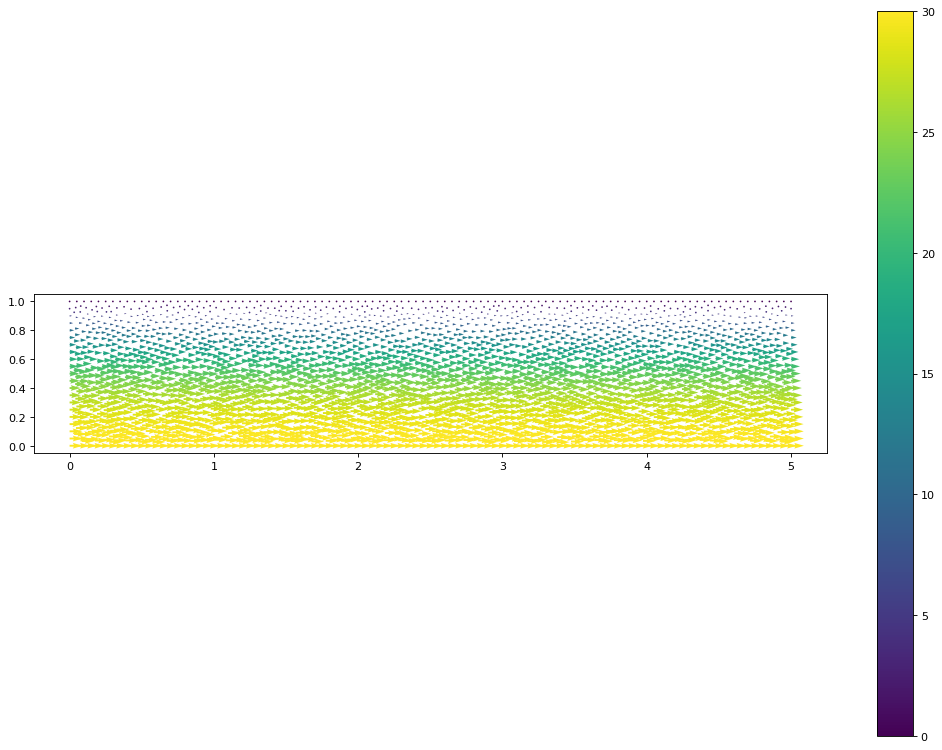

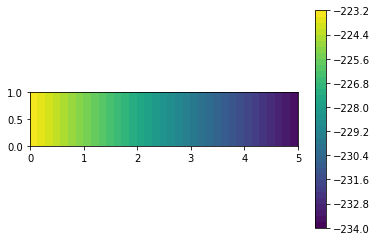

Q = 40, case:no stenosis
u_par_f = -30*x[1]**2 + 30


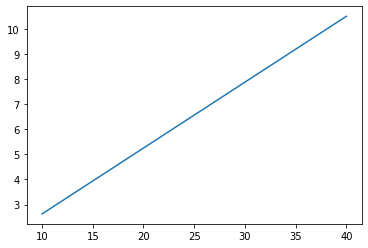

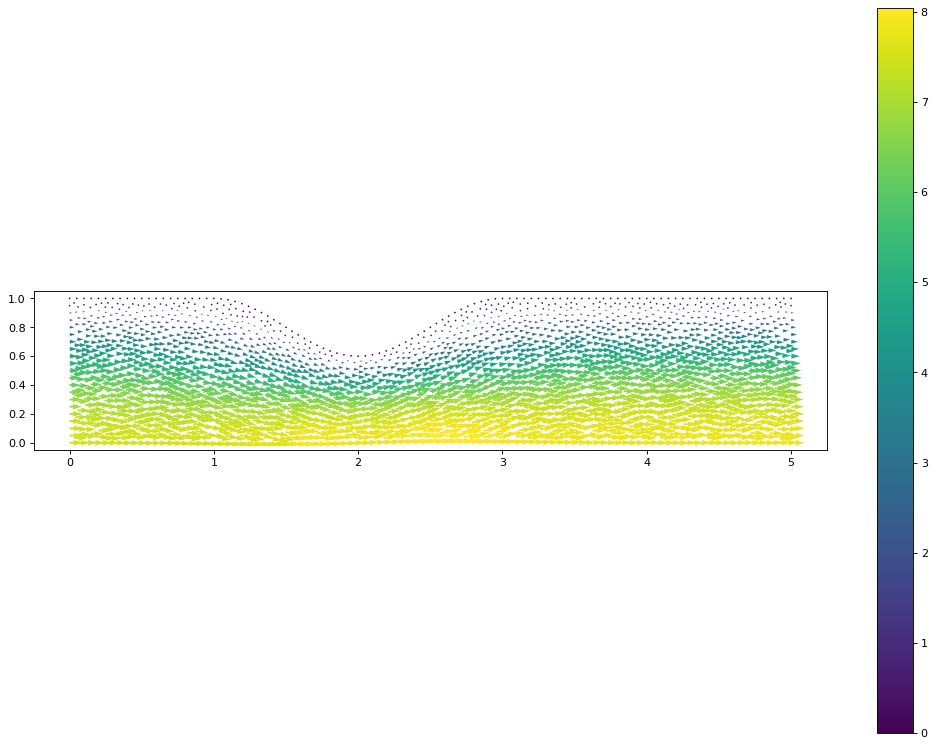

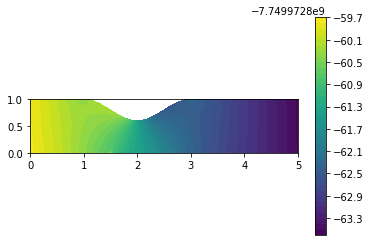

Q = 10, case:stenosis 40
u_par_f = -15*x[1]**2/2 + 15/2


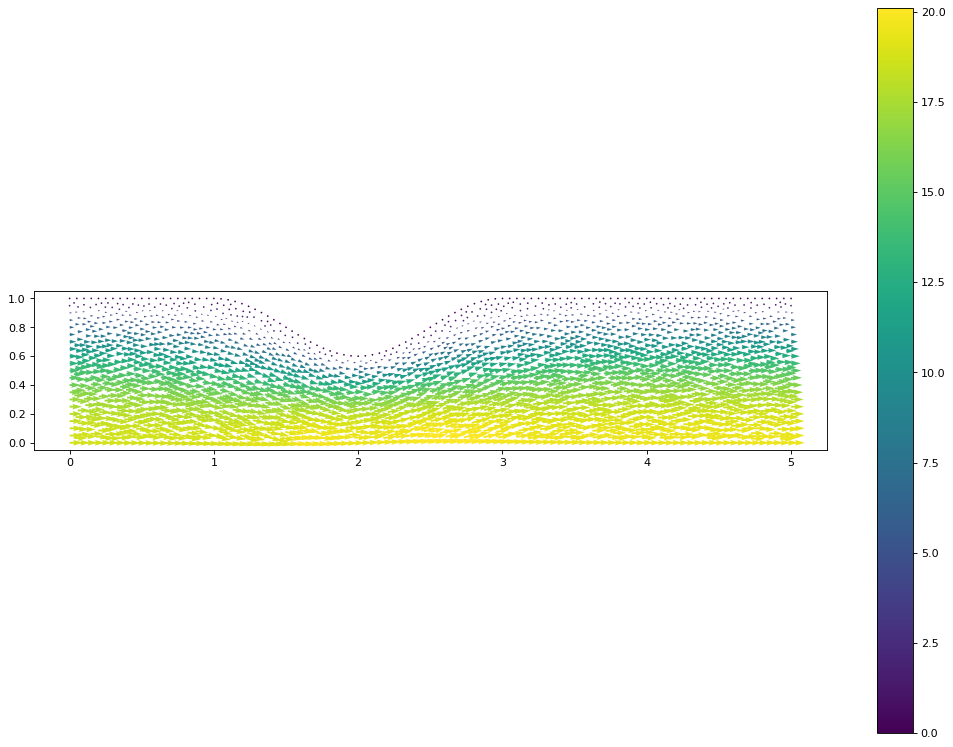

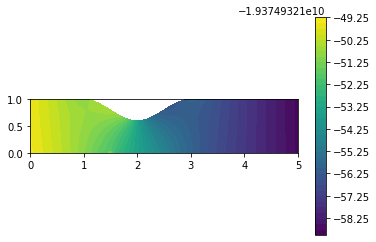

Q = 25, case:stenosis 40
u_par_f = -75*x[1]**2/4 + 75/4


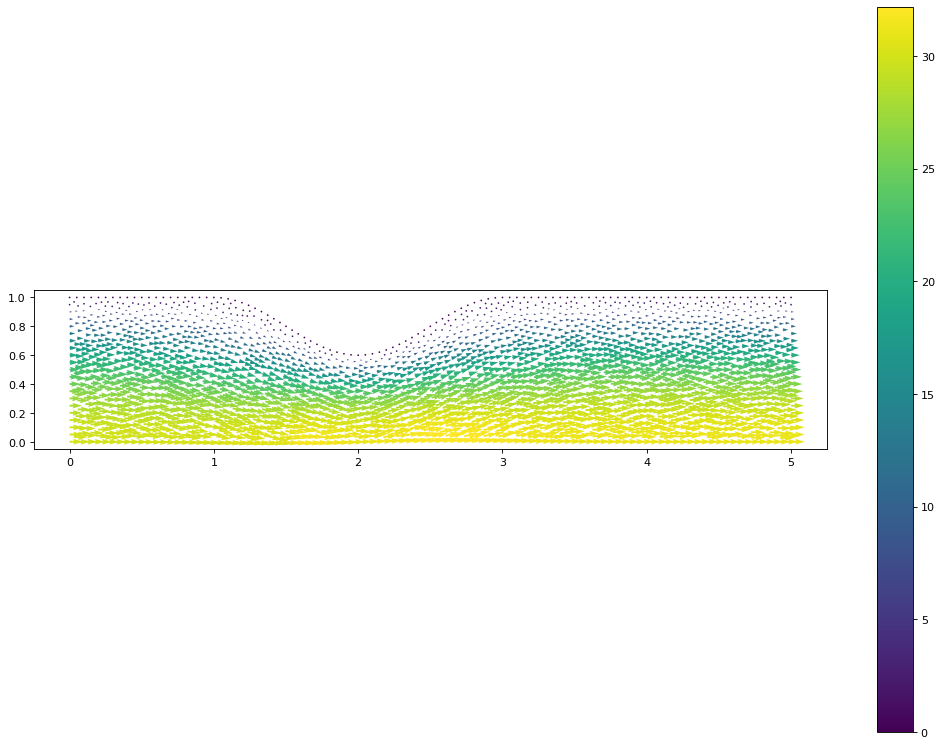

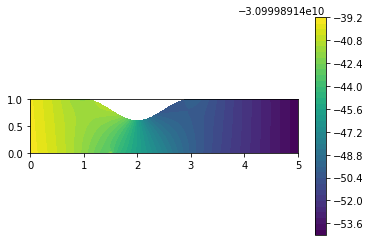

Q = 40, case:stenosis 40
u_par_f = -30*x[1]**2 + 30


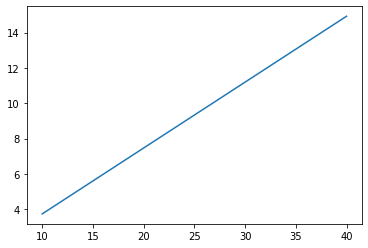

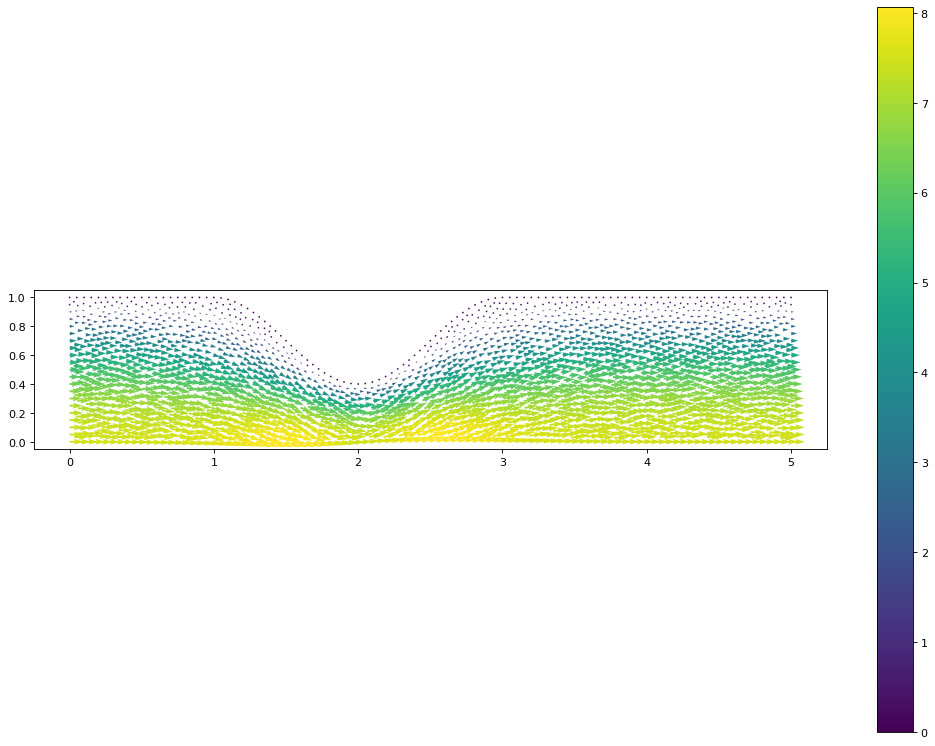

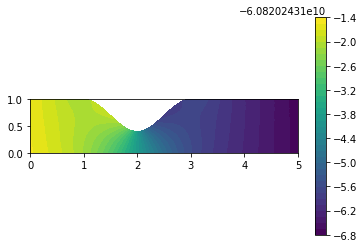

Q = 10, case:stenosis 60
u_par_f = -15*x[1]**2/2 + 15/2


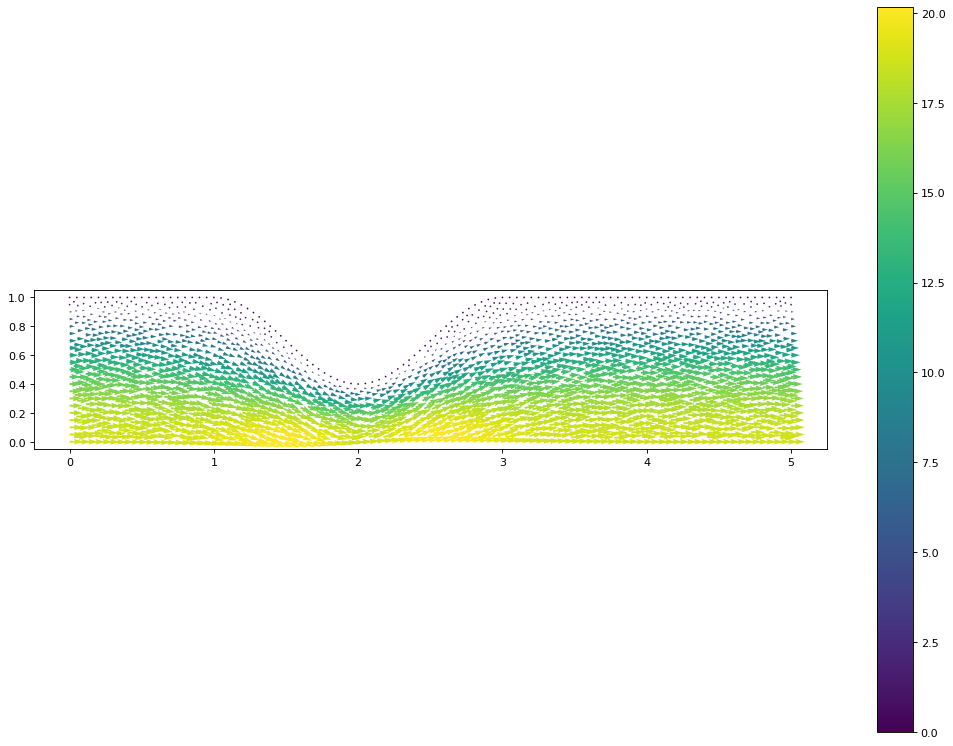

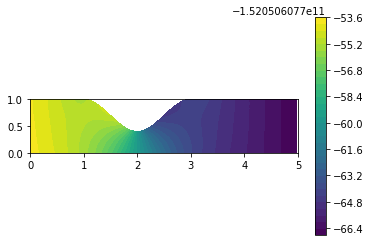

Q = 25, case:stenosis 60
u_par_f = -75*x[1]**2/4 + 75/4


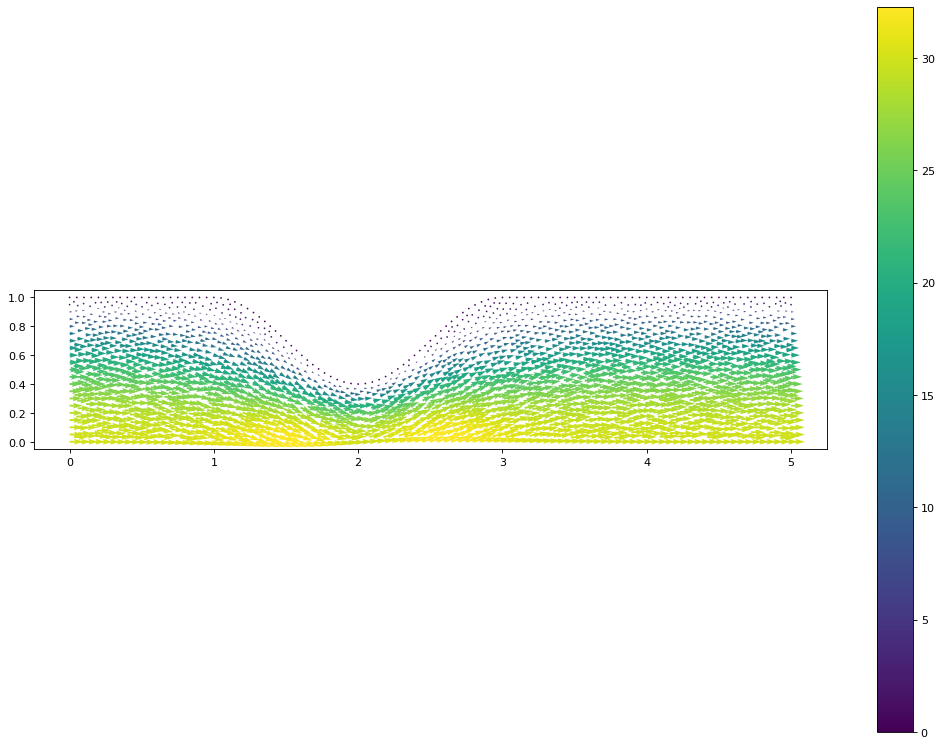

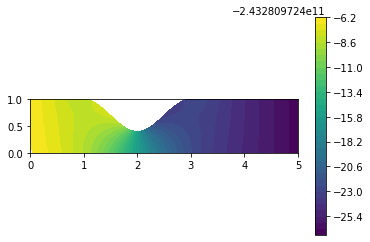

Q = 40, case:stenosis 60
u_par_f = -30*x[1]**2 + 30


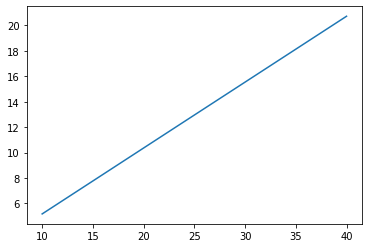

In [5]:
from dolfin import *
import mshr
import sympy as sym

import matplotlib.pyplot as plt

f = Constant((0.0, 0.0))
Q = [10, 25, 40]
mu = 0.035
epsilon = 0

for count1 in range(3):
    sigma_p_arr = []
    for Q_tmp in Q:
        if count1 == 0:
            # Build function space
            mesh = Mesh('no_stenosis.xml')
            boundary = MeshFunction('size_t', mesh,'no_stenosis_facet_region.xml')
        elif count1 == 1:
            # Build function space
            mesh = Mesh('stenosis_f0.4.xml')
            boundary = MeshFunction('size_t', mesh,'stenosis_f0.4_facet_region.xml')
        elif count1 == 2:
            # Build function space
            mesh = Mesh('stenosis_f0.6.xml')
            boundary = MeshFunction('size_t', mesh,'stenosis_f0.6_facet_region.xml')
        P2 = VectorElement("P", mesh.ufl_cell(), 2)
        P1 = FiniteElement("P", mesh.ufl_cell(), 1)
        TH = P2 * P1

        W = FunctionSpace(mesh, TH)
        n = FacetNormal(mesh)
        N = len(boundary)
        
        
        #defining the parabolic profile
        x, y = sym.symbols('x[0], x[1]')            
        u_par = 3*Q_tmp* (-y*y + 1)/4
        u_par = u_par.subs(x, 0)  
        u_par_sum = u_par
        
        u_par = sym.printing.ccode(u_par)
        u_par = Expression((u_par,0), degree=2)
        

        
        ds = Measure('ds', domain=mesh, subdomain_data=boundary)
        boundary_conditions = {1: {'Dirichlet': u_par},   #inflow
                               #2: {'Dirichlet': Constant(0)},   #outflow
                               #3: {'Dirichlet': Constant(0)},   #symmetry
                               4: {'Dirichlet': Constant((0.0, 0.0))}}   #no-slip
        # Collect Dirichlet conditions
        bcs = []
        for i in boundary_conditions:
            if i != 1 and i != 4:
                bc = DirichletBC(W.sub(1), boundary_conditions[i]['Dirichlet'], boundary, i)
            else:
                bc = DirichletBC(W.sub(0), boundary_conditions[i]['Dirichlet'], boundary, i)
            bcs.append(bc)
        # Define variational problem
        (u, p) = TrialFunctions(W)
        (v, q) = TestFunctions(W)

        a = (-mu*inner(grad(u), grad(v)) + div(v)*p + mu*q*div(u) + epsilon/N/mu*inner(grad(q), grad(p)))*dx - inner(p*n, v)*ds
        L = inner(f, v)*dx
        
        U = Function(W)
        solve(a == L, U, bcs)

        # Get sub-functions
        u, p = U.split()

        # Save solution in VTK format
        case_text = ['no stenosis', 'stenosis 40', 'stenosis 60']
        ufile_pvd = File("./images/v_" + case_text[count1] + str(Q_tmp) + ".pvd")
        ufile_pvd << u
        pfile_pvd = File("./images/p_" + case_text[count1] + str(Q_tmp) + ".pvd")
        pfile_pvd << p
        plt.figure(figsize=(16, 12), dpi=80)
        c = plot(u)
        plt.colorbar(c)
        plt.show()

        d = plot(p)
        plt.colorbar(d)
        plt.show()
        print('Q = ', Q_tmp, ', case:', case_text[count1], sep = '')
        print('u_par_f =', u_par_sum )
        sigma_p_arr.append(assemble(p*ds(1))- assemble(p*ds(2)))
    plt.plot(Q, sigma_p_arr)
    plt.show()

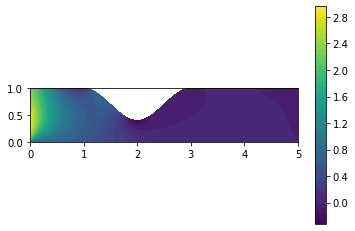

2.578400129417546
Calling FFC just-in-time (JIT) compiler, this may take some time.
-0.0001901229950994049
